In [87]:
from Bio import SeqIO

def get_kmers(seq, K=30):
    start = 0
    end   = len(seq)
    kmers = list()
    ranges= list()
    for i in range(start, end):
        if i > len(seq)-K or ((i+K)>len(seq)):
            break
        else:
            kmers.append(seq[i:i+K])
            ranges.append(f"{i}_{i+K}")
    return kmers, ranges

uniprots = ["P02686", "P07305", "O00488"]
unip = 1

fastafile = f"/data/franco/datasets/disprot/fasta/{uniprots[unip]}.fasta"
K = 50
for record in SeqIO.parse(fastafile, "fasta"):
    seq = record.seq
    print(len(seq))
    kmers, ranges = get_kmers(seq, K=K)
    break

194


In [88]:

kmers_file = f"{uniprots[unip]}_kmers{K}.fasta"
with open(kmers_file, 'w') as outstream:
    for kmer, pos in zip(kmers, ranges):
        print(pos, kmer)
        #print(f">{uniprots[0]}_{pos}")
        outstream.write(f">{uniprots[unip]}_{pos}\n")
        outstream.write(f"{kmer}\n")

0_50 MTENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSI
1_51 TENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQ
2_52 ENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQK
3_53 NSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKY
4_54 STSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYI
5_55 TSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIK
6_56 SAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKS
7_57 APAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKSH
8_58 PAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKSHY
9_59 AAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKSHYK
10_60 AKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKSHYKV
11_61 KPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKSHYKVG
12_62 PKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKSHYKVGE
13_63 KRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKSHYKVGEN
14_64 RAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKSHYKVGENA
15_65 AKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKSHYKVGENAD
16_66 KASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKSHYKVGENADS
17_67 ASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQK

In [91]:
cmd = f"python calc_embeddings.py --model halft5 --fasta {kmers_file} --outdir {uniprots[unip]}_kmers{K}"
print(cmd)
os.system(cmd)

python calc_embeddings.py --model halft5 --fasta P07305_kmers50.fasta --outdir P07305_kmers50
working on P07305_0_50
working on P07305_1_51
working on P07305_2_52
working on P07305_3_53
working on P07305_4_54
working on P07305_5_55
working on P07305_6_56
working on P07305_7_57
working on P07305_8_58
working on P07305_9_59
working on P07305_10_60
working on P07305_11_61
working on P07305_12_62
working on P07305_13_63
working on P07305_14_64
working on P07305_15_65
working on P07305_16_66
working on P07305_17_67
working on P07305_18_68
working on P07305_19_69
working on P07305_20_70
working on P07305_21_71
working on P07305_22_72
working on P07305_23_73
working on P07305_24_74
working on P07305_25_75
working on P07305_26_76
working on P07305_27_77
working on P07305_28_78
working on P07305_29_79
working on P07305_30_80
working on P07305_31_81
working on P07305_32_82
working on P07305_33_83
working on P07305_34_84
working on P07305_35_85
working on P07305_36_86
working on P07305_37_87
work

0

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

embeddir = f"{uniprots[unip]}_kmers{K}/halft5"
filelist = os.listdir(embeddir)
embeddings = list()
for i in range(len(filelist)):
    filename = f"{uniprots[unip]}_{0+i}_{K+i}.gz"
    filepath = os.path.join(embeddir, filename)
    embedding = np.loadtxt(filepath)
    embeddings.append(embedding)

In [93]:
orig_embedding = np.loadtxt(f"/data/franco/datasets/prot_embedding_weights/disprot/halft5/{uniprots[unip]}.gz")

In [94]:
orig_embedding.shape

(194, 1024)

In [95]:
from scipy.spatial import distance

def get_cosdist(u, v):
    values = list()
    if u.shape[0] == v.shape[0]:
        for i in range(u.shape[0]):
            values.append(distance.cosine(u[i,:], v[i,:]))
    return values

cos_distances = list()
for i,r in enumerate(ranges):
    arr = r.split("_")
    s   = int(arr[0])
    e   = int(arr[1])
    cut_kmer  = orig_embedding[s:e,:]
    orig_kmer = embeddings[i]
    # print(cut_kmer.shape, orig_kmer.shape)
    cos_dist = get_cosdist(cut_kmer, orig_kmer)
#     cos_dist = get_cosdist(cut_kmer, cut_kmer)
    cos_distances.append(cos_dist)

In [96]:
image_matrix = np.zeros((len(cos_distances), len(seq)))
for i,r in enumerate(ranges):
    arr = r.split("_")
    s   = int(arr[0])
    e   = int(arr[1])
    image_matrix[i, s:e] = cos_distances[i]

194


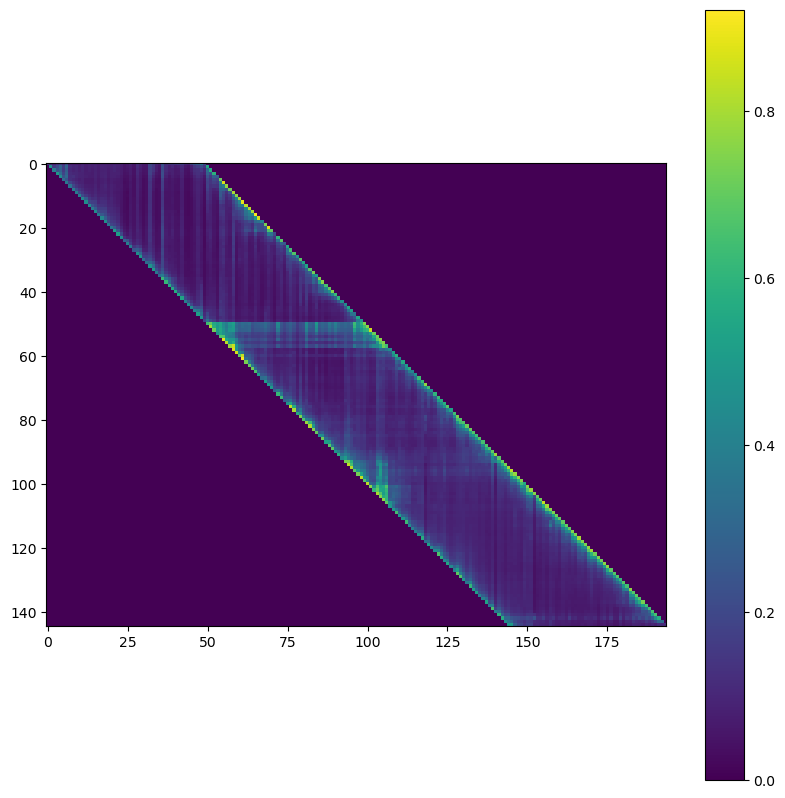

In [97]:
print(len(seq))
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111)
im  = ax.imshow(image_matrix)
fig.colorbar(im)
plt.show()

In [101]:
import umap

my_umap = umap.UMAP(n_neighbors=30, min_dist=.25)
umap_embedding = my_umap.fit_transform(embeddings)


ValueError: Found array with dim 3. Estimator expected <= 2.

In [100]:
embeddings_array = np.array(embeddings)
embeddings_array.shape

(145, 50, 1024)